### init

In [1]:
import numpy as np
from scipy.special import jv, yv
import pandas as pd

# LSRK5 係數 (Carpenter & Kennedy 1994)
A = np.array([0.0,
              -567301805773.0 / 1357537059087.0,
              -2404267990393.0 / 2016746695238.0,
              -3550918686646.0 / 2091501179385.0,
              -1275806237668.0 / 842570457699.0])

B = np.array([1432997174477.0 / 9575080441755.0,
              5161836677717.0 / 13612068292357.0,
              1720146321549.0 / 2090206949498.0,
              3134564353537.0 / 4481467310338.0,
              2277821191437.0 / 14882151754819.0])

C = np.array([0.0, 0.1496590219993, 0.3704009573644, 0.6222557631345, 0.9582821306748])

# 問題參數
n = 8
c = 1.0
alpha = 6.1556542986056666
omega = alpha * c

In [2]:
def exact_solution(r, theta, t, n, alpha, omega):
    """解析解"""
    A_coef = 1.0
    B_coef = -A_coef * jv(n, alpha * 1) / yv(n, alpha * 1)
    hat_u = A_coef * jv(n, alpha * r) + B_coef * yv(n, alpha * r)
    u = hat_u * np.cos(n * theta - omega * t)
    u_t = omega * hat_u * np.sin(n * theta - omega * t)
    return u, u_t

def construct_D_matrix(N):
    """構建偽譜微分矩陣"""
    D = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            if i != j:
                diff = i - j
                D[i, j] = ((-1)**diff) / (2 * np.tan(np.pi * diff / N))
    return D

def f_theta_numerical(u, R_inv2, N, D2):
    """
    角度項數值計算
    Args:
        u: 解矩陣，形狀 (K+1, N)
        R_inv2: 對角矩陣 diag(1 / r_k^2)，形狀 (K+1, K+1)
        N: 角度格點數
        D2: 二階微分矩陣 (N, N)
    Returns:
        f_theta: 角度項，形狀 (K+1, N)
    """
    result = R_inv2 @ u @ D2  # 矩陣乘法，形狀 (K+1, N)
    return result

def precompute_radial_derivatives(r_arr, Theta, n, alpha):
    """預計算所有半網格點的徑向導數係數（時間無關部分）"""
    K = len(r_arr) - 1  # 內部網格點數
    N = Theta.shape[1]
    
    # 半網格點位置
    r_half = np.zeros(K)
    for k in range(K):
        r_half[k] = (r_arr[k] + r_arr[k+1]) / 2
    
    # 預計算徑向導數的空間部分（時間無關）
    A_coef = 1.0
    B_coef = -A_coef * jv(n, alpha * 1) / yv(n, alpha * 1)
    
    radial_coeff = np.zeros(K)  # 只需要 K 個值，因為對所有角度點都相同
    for k in range(K):
        r_val = r_half[k]
        # 計算 Bessel 函數的導數
        djv_dr = alpha * (jv(n-1, alpha * r_val) - jv(n+1, alpha * r_val)) / 2
        dyv_dr = alpha * (yv(n-1, alpha * r_val) - yv(n+1, alpha * r_val)) / 2
        hat_u_r = A_coef * djv_dr + B_coef * dyv_dr
        
        radial_coeff[k] = r_val * hat_u_r
    
    return radial_coeff

def compute_ru_r_half_grid_optimized(radial_coeff, Theta, t, n, omega):
    """使用預計算的係數快速計算半網格點上的 ru_r（矩陣加速版）"""
    cos_term = np.cos(n * Theta[0, :] - omega * t)  # shape: (N,)
    
    # 向量化：radial_coeff shape (K,) -> (K, 1), cos_term shape (N,) -> (1, N)
    ru_r_half = radial_coeff[:, np.newaxis] * cos_term[np.newaxis, :]  # shape: (K, N)
    
    return ru_r_half


def f_r_numerical_optimized(u, r_arr, radial_coeff, Theta, t, n, omega):
    """徑向項數值計算 - 矩陣加速版本，使用預計算的徑向導數"""
    K = len(r_arr) - 1
    dr = 1.0 / K
    N = u.shape[1]
    
    # 使用預計算的係數快速計算半網格點上的 ru_r
    ru_r_half = compute_ru_r_half_grid_optimized(radial_coeff, Theta, t, n, omega)  # shape = (K, N)

    # 計算內部點的徑向項：向量化處理
    r_k = r_arr[1:K].reshape(-1, 1)  # shape = (K-1, 1)
    numerator = ru_r_half[1:K, :] - ru_r_half[0:K-1, :]  # shape = (K-1, N)
    f_r_inner = numerator / (r_k * dr)  # shape = (K-1, N)

    # 初始化結果陣列
    f_r = np.zeros_like(u)
    f_r[1:K, :] = f_r_inner

    # 邊界點 k=0 和 k=K 已經是 0，不需要額外設定（除非你要明確指定）
    f_r[0, :] = 0.0
    f_r[K, :] = 0.0

    return f_r


def enforce_boundary_conditions(u, v):
    """強加 Dirichlet 邊界條件 u=0"""
    u[0, :] = 0.0   # r=1 邊界
    u[-1, :] = 0.0  # r=2 邊界
    v[0, :] = 0.0   # r=1 邊界
    v[-1, :] = 0.0  # r=2 邊界

def rhs_system_part4_optimized(u, v, radial_coeff, r_arr, N, Theta, t, n, omega, D2, R_inv2):
    """系統右端項 - Part IV 優化版本"""
    du_dt = v
    dv_dt = f_r_numerical_optimized(u, r_arr, radial_coeff, Theta, t, n, omega) + f_theta_numerical(u, R_inv2, N, D2)
    return du_dt, dv_dt

### normal

環形波動3D動畫可視化 - 修正版本
開始創建3D動畫 (K=160, N=192, frames=100)...
計算動畫幀...
計算幀 20/100, t=0.1959
計算幀 40/100, t=0.4021
計算幀 60/100, t=0.6083
計算幀 80/100, t=0.8145
計算幀 100/100, t=1.0207
共生成 100 幀數據
創建3D動畫...
開始渲染動畫...
保存動畫為GIF文件...


/var/folders/xw/460kbmwd03b4w67v8f_qdh800000gn/T/ipykernel_29879/4282836497.py:108: UserWarning: Glyph 29872 (\N{CJK UNIFIED IDEOGRAPH-74B0}) missing from font(s) DejaVu Sans.
  anim.save('ring_wave_3d_animation_fixed.gif', writer='pillow', fps=10, dpi=60)
/var/folders/xw/460kbmwd03b4w67v8f_qdh800000gn/T/ipykernel_29879/4282836497.py:108: UserWarning: Glyph 24418 (\N{CJK UNIFIED IDEOGRAPH-5F62}) missing from font(s) DejaVu Sans.
  anim.save('ring_wave_3d_animation_fixed.gif', writer='pillow', fps=10, dpi=60)
/var/folders/xw/460kbmwd03b4w67v8f_qdh800000gn/T/ipykernel_29879/4282836497.py:108: UserWarning: Glyph 27874 (\N{CJK UNIFIED IDEOGRAPH-6CE2}) missing from font(s) DejaVu Sans.
  anim.save('ring_wave_3d_animation_fixed.gif', writer='pillow', fps=10, dpi=60)
/var/folders/xw/460kbmwd03b4w67v8f_qdh800000gn/T/ipykernel_29879/4282836497.py:108: UserWarning: Glyph 21205 (\N{CJK UNIFIED IDEOGRAPH-52D5}) missing from font(s) DejaVu Sans.
  anim.save('ring_wave_3d_animation_fixed.gif', write

動畫已保存為 'ring_wave_3d_animation_fixed.gif'


/var/folders/xw/460kbmwd03b4w67v8f_qdh800000gn/T/ipykernel_29879/4282836497.py:114: UserWarning: Glyph 29872 (\N{CJK UNIFIED IDEOGRAPH-74B0}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/xw/460kbmwd03b4w67v8f_qdh800000gn/T/ipykernel_29879/4282836497.py:114: UserWarning: Glyph 24418 (\N{CJK UNIFIED IDEOGRAPH-5F62}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/xw/460kbmwd03b4w67v8f_qdh800000gn/T/ipykernel_29879/4282836497.py:114: UserWarning: Glyph 27874 (\N{CJK UNIFIED IDEOGRAPH-6CE2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/xw/460kbmwd03b4w67v8f_qdh800000gn/T/ipykernel_29879/4282836497.py:114: UserWarning: Glyph 21205 (\N{CJK UNIFIED IDEOGRAPH-52D5}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/user/code/.conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 29872 (\N{CJK UNIFIED IDEOGRAPH-74B0}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io,

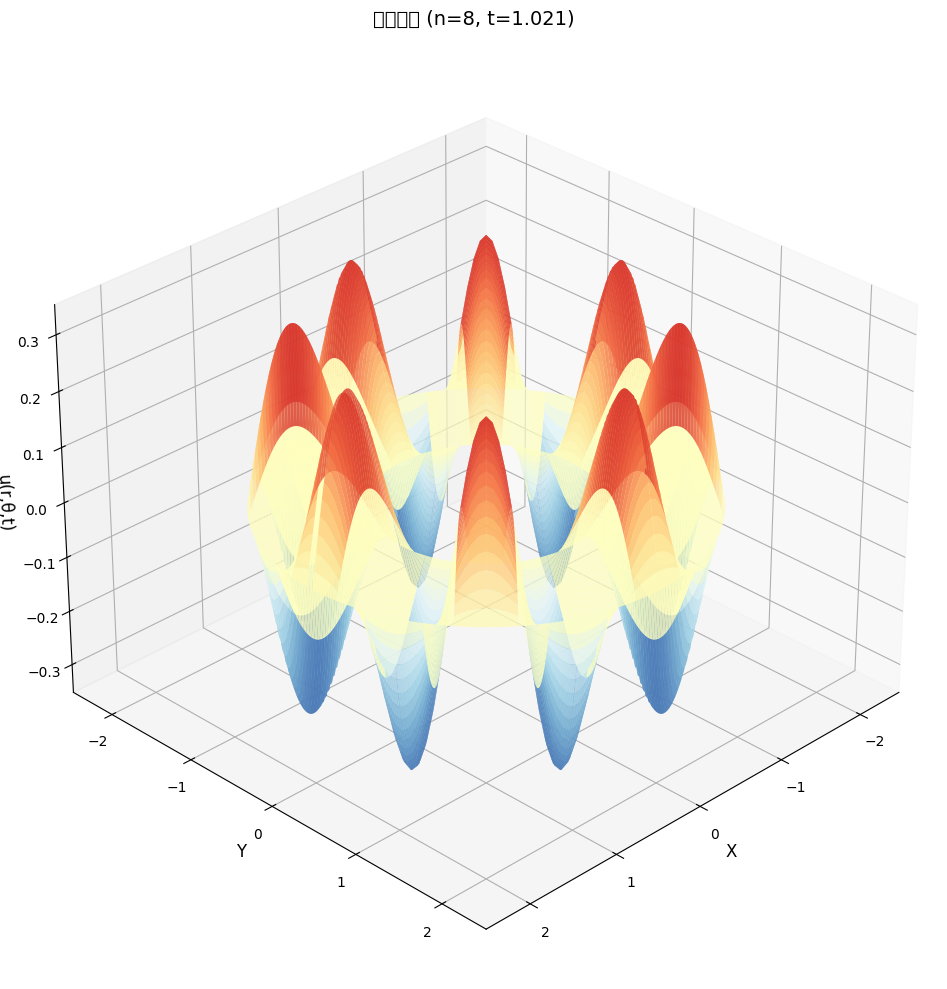

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from matplotlib.colors import Normalize
import matplotlib.cm as cm

def create_3d_animation_fixed(K=80, N=96, num_frames=100, save_animation=True):
    """
    創建環形波動的3D動畫 - 修正版本
    
    Args:
        K: 徑向網格點數-1 (減少以加快計算)
        N: 角度網格點數 (減少以加快計算)
        num_frames: 動畫幀數 (減少以加快渲染)
        save_animation: 是否保存動畫文件
    """
    print(f"開始創建3D動畫 (K={K}, N={N}, frames={num_frames})...")
    
    # 設置參數
    D = construct_D_matrix(N)
    D2 = D.T @ D.T
    
    # 網格設置
    r = np.linspace(1, 2, K + 1)
    R_inv2 = np.diag(1 / r**2)
    theta = np.linspace(0, 2 * np.pi, N, endpoint=False)
    dr = 1 / K
    dtheta = 2 * np.pi / N
    R, Theta = np.meshgrid(r, theta, indexing='ij')
    
    # 預計算徑向導數係數
    radial_coeff = precompute_radial_derivatives(r, Theta, n, alpha)
    
    # 時間設置
    T_total = 2 * np.pi / alpha  # 一個完整周期
    
    # 改進的時間步進策略：固定動畫時間步長
    animation_dt = T_total / num_frames
    animation_times = np.linspace(0, T_total, num_frames)
    
    # 轉換為笛卡爾座標用於繪圖
    X = R * np.cos(Theta)
    Y = R * np.sin(Theta)
    
    # 存儲動畫數據
    solutions = []
    
    print("計算動畫幀...")
    
    # 為每個動畫時間點計算解
    for frame_idx, t_anim in enumerate(animation_times):
        # 直接使用解析解來生成動畫幀（更穩定和快速）
        u_frame, _ = exact_solution(R, Theta, t_anim, n, alpha, omega)
        enforce_boundary_conditions(u_frame, u_frame)
        solutions.append(u_frame.copy())
        
        if (frame_idx + 1) % 20 == 0:
            print(f"計算幀 {frame_idx+1}/{num_frames}, t={t_anim:.4f}")
    
    print(f"共生成 {len(solutions)} 幀數據")
    
    # 創建3D動畫
    print("創建3D動畫...")
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # 設置顏色範圍
    u_min = min(np.min(sol) for sol in solutions)
    u_max = max(np.max(sol) for sol in solutions)
    norm = Normalize(vmin=u_min, vmax=u_max)
    
    def animate(frame_num):
        ax.clear()
        
        # 取得當前幀的解
        Z = solutions[frame_num]
        
        # 繪製3D表面
        surf = ax.plot_surface(X, Y, Z, cmap='RdYlBu_r', norm=norm, 
                              alpha=0.8, linewidth=0, antialiased=True)
        
        # 設置軸標籤和標題
        ax.set_xlabel('X', fontsize=12)
        ax.set_ylabel('Y', fontsize=12)
        ax.set_zlabel('u(r,θ,t)', fontsize=12)
        ax.set_title(f'環形波動 (n={n}, t={animation_times[frame_num]:.3f})', 
                    fontsize=14, pad=20)
        
        # 設置視角 - 加入旋轉效果
        ax.view_init(elev=30, azim=45)  # 慢慢旋轉視角
        
        # 設置軸範圍
        ax.set_xlim([-2.5, 2.5])
        ax.set_ylim([-2.5, 2.5])
        ax.set_zlim([u_min * 1.1, u_max * 1.1])
        
        return surf,
    
    # 創建動畫
    print("開始渲染動畫...")
    anim = animation.FuncAnimation(fig, animate, frames=len(solutions), 
                                  interval=100, blit=False, repeat=True)
    
    # 保存動畫
    if save_animation:
        try:
            print("保存動畫為GIF文件...")
            anim.save('ring_wave_3d_animation_fixed.gif', writer='pillow', fps=10, dpi=60)
            print("動畫已保存為 'ring_wave_3d_animation_fixed.gif'")
        except Exception as e:
            print(f"保存動畫時出錯: {e}")
            print("請確保已安裝pillow: pip install pillow")
    
    plt.tight_layout()
    plt.show()
    
    return anim

# 創建修正版本的3D動畫（參數調整為更合理的值）
print("="*50)
print("環形波動3D動畫可視化 - 修正版本")
print("="*50)
anim = create_3d_animation_fixed(K=160, N=192, num_frames=100, save_animation=True)

### smooth

環形波動3D動畫可視化 - 高質量平滑版本
開始創建平滑3D動畫 (K=120, N=240, frames=120)...
計算動畫幀...
計算幀 30/120, t=0.2487
計算幀 60/120, t=0.5061
計算幀 90/120, t=0.7634
計算幀 120/120, t=1.0207
共生成 120 幀數據
創建3D動畫...
開始渲染動畫...
保存動畫為GIF文件...


/var/folders/xw/460kbmwd03b4w67v8f_qdh800000gn/T/ipykernel_29879/1637101316.py:136: UserWarning: Glyph 29872 (\N{CJK UNIFIED IDEOGRAPH-74B0}) missing from font(s) DejaVu Sans.
  anim.save('ring_wave_3d_smooth_animation.gif', writer='pillow', fps=12, dpi=80)
/var/folders/xw/460kbmwd03b4w67v8f_qdh800000gn/T/ipykernel_29879/1637101316.py:136: UserWarning: Glyph 24418 (\N{CJK UNIFIED IDEOGRAPH-5F62}) missing from font(s) DejaVu Sans.
  anim.save('ring_wave_3d_smooth_animation.gif', writer='pillow', fps=12, dpi=80)
/var/folders/xw/460kbmwd03b4w67v8f_qdh800000gn/T/ipykernel_29879/1637101316.py:136: UserWarning: Glyph 27874 (\N{CJK UNIFIED IDEOGRAPH-6CE2}) missing from font(s) DejaVu Sans.
  anim.save('ring_wave_3d_smooth_animation.gif', writer='pillow', fps=12, dpi=80)
/var/folders/xw/460kbmwd03b4w67v8f_qdh800000gn/T/ipykernel_29879/1637101316.py:136: UserWarning: Glyph 21205 (\N{CJK UNIFIED IDEOGRAPH-52D5}) missing from font(s) DejaVu Sans.
  anim.save('ring_wave_3d_smooth_animation.gif', w

動畫已保存為 'ring_wave_3d_smooth_animation.gif'


/var/folders/xw/460kbmwd03b4w67v8f_qdh800000gn/T/ipykernel_29879/1637101316.py:142: UserWarning: Glyph 29872 (\N{CJK UNIFIED IDEOGRAPH-74B0}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/xw/460kbmwd03b4w67v8f_qdh800000gn/T/ipykernel_29879/1637101316.py:142: UserWarning: Glyph 24418 (\N{CJK UNIFIED IDEOGRAPH-5F62}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/xw/460kbmwd03b4w67v8f_qdh800000gn/T/ipykernel_29879/1637101316.py:142: UserWarning: Glyph 27874 (\N{CJK UNIFIED IDEOGRAPH-6CE2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/xw/460kbmwd03b4w67v8f_qdh800000gn/T/ipykernel_29879/1637101316.py:142: UserWarning: Glyph 21205 (\N{CJK UNIFIED IDEOGRAPH-52D5}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/user/code/.conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 29872 (\N{CJK UNIFIED IDEOGRAPH-74B0}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io,

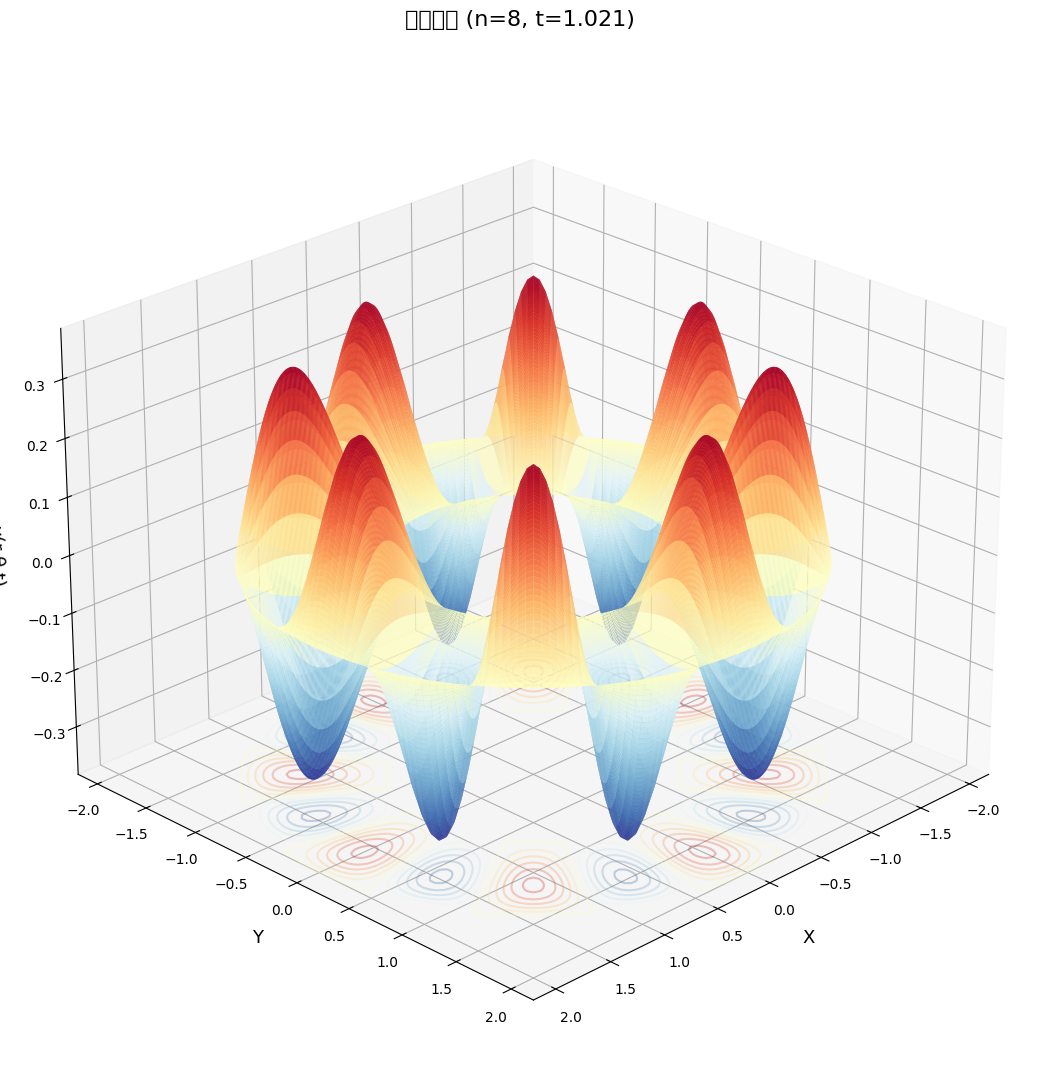

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from scipy.interpolate import griddata

def create_3d_animation_smooth(K=120, N=240, num_frames=120, save_animation=True, interpolation_factor=2):
    """
    創建環形波動的3D動畫 - 平滑優化版本
    
    Args:
        K: 徑向網格點數-1 (增加以提高平滑度)
        N: 角度網格點數 (增加以提高平滑度)
        num_frames: 動畫幀數
        save_animation: 是否保存動畫文件
        interpolation_factor: 插值增強因子，用於進一步平滑
    """
    print(f"開始創建平滑3D動畫 (K={K}, N={N}, frames={num_frames})...")
    
    # 設置參數
    D = construct_D_matrix(N)
    D2 = D.T @ D.T
    
    # 網格設置 - 確保角度方向的周期性連續
    r = np.linspace(1, 2, K + 1)
    R_inv2 = np.diag(1 / r**2)
    
    # 角度網格 - 包含端點以確保周期性連續
    theta = np.linspace(0, 2 * np.pi, N + 1)  # 包含端點
    theta = theta[:-1]  # 移除最後一個點以避免重複
    
    dr = 1 / K
    dtheta = 2 * np.pi / N
    R, Theta = np.meshgrid(r, theta, indexing='ij')
    
    # 預計算徑向導數係數
    radial_coeff = precompute_radial_derivatives(r, Theta, n, alpha)
    
    # 時間設置
    T_total = 2 * np.pi / alpha  # 一個完整周期
    animation_times = np.linspace(0, T_total, num_frames)
    
    # 為了確保角度方向的周期性連續，我們需要在theta方向添加重複點
    theta_extended = np.append(theta, theta[0])  # 添加第一個角度點到末尾
    R_ext, Theta_ext = np.meshgrid(r, theta_extended, indexing='ij')
    
    # 轉換為笛卡爾座標用於繪圖
    X = R_ext * np.cos(Theta_ext)
    Y = R_ext * np.sin(Theta_ext)
    
    # 存儲動畫數據
    solutions = []
    
    print("計算動畫幀...")
    
    # 為每個動畫時間點計算解
    for frame_idx, t_anim in enumerate(animation_times):
        # 計算解
        u_frame, _ = exact_solution(R, Theta, t_anim, n, alpha, omega)
        enforce_boundary_conditions(u_frame, u_frame)
        
        # 擴展解以確保角度方向的周期性連續
        u_frame_extended = np.column_stack([u_frame, u_frame[:, 0]])
        
        solutions.append(u_frame_extended.copy())
        
        if (frame_idx + 1) % 30 == 0:
            print(f"計算幀 {frame_idx+1}/{num_frames}, t={t_anim:.4f}")
    
    print(f"共生成 {len(solutions)} 幀數據")
    
    # 創建3D動畫
    print("創建3D動畫...")
    fig = plt.figure(figsize=(14, 11))
    ax = fig.add_subplot(111, projection='3d')
    
    # 設置顏色範圍
    u_min = min(np.min(sol) for sol in solutions)
    u_max = max(np.max(sol) for sol in solutions)
    color_range = max(abs(u_min), abs(u_max))
    norm = Normalize(vmin=-color_range, vmax=color_range)  # 對稱顏色範圍
    
    def animate(frame_num):
        ax.clear()
        
        # 取得當前幀的解
        Z = solutions[frame_num]
        
        # 繪製3D表面 - 優化參數以獲得更平滑的效果
        surf = ax.plot_surface(X, Y, Z, 
                              cmap='RdYlBu_r', 
                              norm=norm,
                              alpha=0.9,
                              linewidth=0,
                              antialiased=True,
                              rstride=1,  # 降低采樣步長以提高平滑度
                              cstride=1,
                              shade=True,  # 啟用陰影以增強3D效果
                              lightsource=None)  # 使用默認光源
        
        # 添加等高線投影到底面（可選）
        contours = ax.contour(X, Y, Z, zdir='z', offset=u_min*1.2, 
                             cmap='RdYlBu_r', alpha=0.3, levels=10)
        
        # 設置軸標籤和標題
        ax.set_xlabel('X', fontsize=13, labelpad=10)
        ax.set_ylabel('Y', fontsize=13, labelpad=10)
        ax.set_zlabel('u(r,θ,t)', fontsize=13, labelpad=10)
        ax.set_title(f'環形波動 (n={n}, t={animation_times[frame_num]:.3f})', 
                    fontsize=16, pad=25)
        
        # 設置視角 - 固定視角以避免不必要的旋轉
        ax.view_init(elev=25, azim=45)
        
        # 設置軸範圍
        ax.set_xlim([-2.2, 2.2])
        ax.set_ylim([-2.2, 2.2])
        ax.set_zlim([u_min * 1.2, u_max * 1.2])
        
        # 改善軸刻度和網格
        ax.tick_params(axis='both', which='major', labelsize=10)
        ax.grid(True, alpha=0.3)
        
        return surf,
    
    # 創建動畫
    print("開始渲染動畫...")
    anim = animation.FuncAnimation(fig, animate, frames=len(solutions), 
                                  interval=80, blit=False, repeat=True)
    
    # 保存動畫
    if save_animation:
        try:
            print("保存動畫為GIF文件...")
            anim.save('ring_wave_3d_smooth_animation.gif', writer='pillow', fps=12, dpi=80)
            print("動畫已保存為 'ring_wave_3d_smooth_animation.gif'")
        except Exception as e:
            print(f"保存動畫時出錯: {e}")
            print("請確保已安裝pillow: pip install pillow")
    
    plt.tight_layout()
    plt.show()
    
    return anim

# 創建高質量平滑的3D動畫
print("="*60)
print("環形波動3D動畫可視化 - 高質量平滑版本")
print("="*60)
anim_smooth = create_3d_animation_smooth(K=120, N=240, num_frames=120, save_animation=True)